### 🤖 What are Multi-Agent RAG Systems?
A Multi-Agent RAG System splits the RAG pipeline into multiple specialized agents — each responsible for a specific role — and enables them to collaborate on a single query or task.

#### 1. 📋 Multi-Agent Network RAG System with LangGraph
Project Overview

A beginner-friendly Retrieval-Augmented Generation (RAG) system that uses a multi-agent architecture to intelligently answer questions from your documents. Built with LangGraph v0.3 for workflow orchestration and OpenAI for language understanding.

What It Does

Transforms your documents (PDFs, text files) into a searchable knowledge base that can answer questions intelligently using AI. Simply upload documents and ask questions in natural language - the system finds relevant information and generates comprehensive answers.
Key Features

- 📚 Multi-Format Support: Handles PDF and text documents
- 🤖 3-Agent Architecture: Specialized agents for document processing, retrieval, and answer generation
- 🔍 Smart Search: Vector-based semantic search finds relevant information
- 💬 Natural Language Q&A: Ask questions in plain English


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model
os.environ["TAVILY_API_KEY"]="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"

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [4]:
llm=init_chat_model("openai:gpt-4o-mini")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000238B441BA10>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000238B4870590>, root_client=<openai.OpenAI object at 0x00000238B4418C20>, root_async_client=<openai.AsyncOpenAI object at 0x00000238B48702F0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [8]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [6]:
tavily_tool=TavilySearch(max_results=5)

In [9]:
### generic function to create a retrieval tool
from langchain.agents import Tool
def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1=make_retriever_tool_from_text("internal_docs.txt",
                                              "InternalResearchNotes",
                                              "Search internal research notes for experimental results")

internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x00000238B4055E40>)

In [10]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [11]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

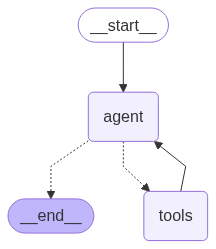

In [12]:
### Reaearch agent and node

research_agent=create_react_agent(
    llm,
    tools=[internal_tool_1,tavily_tool],
    prompt=make_system_prompt("You can only do research. Use the tool that you are binded with, you can use both of them" \
    " You are working with a content writer colleague.")
)

research_agent

In [13]:
## Reaearch node
from typing import Literal
def research_node(state:MessagesState)-> Command[Literal["blog_generator",END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "blog_generator")

    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )



In [14]:
### Blog write agent
blog_agent=create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        "You can only write a detailed blog. You are working with a researcher colleague."
    )
)

def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = blog_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="blog_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

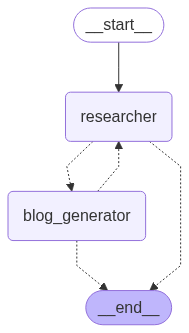

In [15]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()
graph

In [17]:
response=graph.invoke({"messages":"Write a detailed blog on transformer variants in production deployments"})

📚 Using tool: InternalResearchNotes


In [18]:
response["messages"][-1].content

'FINAL ANSWER\n\n# Transformer Variants in Production Deployments\n\nTransformer models have revolutionized the field of natural language processing (NLP) and have found extensive applications across various domains, from machine translation to sentiment analysis. Their versatility, speed, and performance make them a preferred choice for contemporary AI applications. In production deployments, multiple variants of these models have been adopted, each optimized for specific tasks, environments, or constraints. In this blog post, we will analyze several notable transformer variants, their use cases, deployment strategies, and best practices.\n\n## 1. Types of Transformer Models\n\n### a. BERT (Bidirectional Encoder Representations from Transformers)\n\nBERT is an auto-encoding transformer model designed primarily for language understanding tasks. It analyzes text from both directions (left-to-right and right-to-left), which allows it to better grasp the context of words in a sentence. BE

### Multi Agent Suprvisor With RAG
Supervisor is a multi-agent architecture where specialized agents are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

In this tutorial, you will build a supervisor system with two agents — a research and a math expert. By the end of the tutorial you will:

1. Build specialized research and math agents
2. Build a supervisor for orchestrating them with the prebuilt langgraph-supervisor
3. Build a supervisor 
4. Implement advanced task delegation


In [19]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x00000238B4055E40>)

In [21]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search

TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

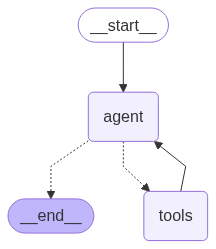

In [22]:
from langgraph.prebuilt import create_react_agent

research_agent=create_react_agent(
    model=llm,
    tools=[web_search,internal_tool_1],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent"
)
research_agent

In [23]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent=create_react_agent(
    model=llm,
    tools=[add,multiply,divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent"

)

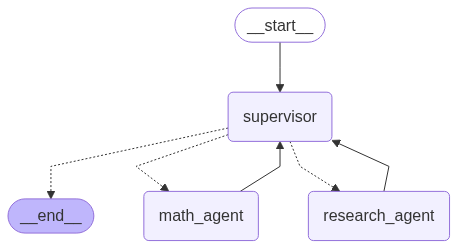

In [24]:
### create supervisor agent

from langgraph_supervisor import create_supervisor
supervisor=create_supervisor(
    model=llm,
    agents=[research_agent,math_agent],
    prompt=(
         "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."

    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

supervisor

In [25]:
response=supervisor.invoke({"messages":" list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10"})

📚 Using tool: InternalResearchNotes


In [26]:
response

{'messages': [HumanMessage(content=' list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10', additional_kwargs={}, response_metadata={}, id='e9301418-3ec6-46e2-bcf0-201b432514f5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FqDcoD0mCS3oDvbnIlH7HMLQ', 'function': {'arguments': '{}', 'name': 'transfer_to_research_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 142, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1vGwjil4WHelhpYBpjei3B1NbEsz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--72f88eae-

In [27]:
response["messages"][-1].content

'The transformer variants in production deployments include:\n\n1. **EfficientFormer**: Optimized for mobile inference.\n2. **Reformer**: Tested for memory efficiency on embedded devices.\n\nAdditionally, Vision Transformers (ViT and Swin Transformer) and Speech Transformers (Wav2Vec 2.0) were also evaluated.\n\nAs for the math question, 5 plus 10 equals 15.'

### Hierarchical Agent Teams With RAG
In our previous example (Agent Supervisor), we introduced the concept of a single supervisor node to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed hierarchically.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

In [28]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [29]:
@tool
def scrape_webpages(urls:List[str])->str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )


In [30]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [48]:
WORKING_DIRECTORY

WindowsPath('C:/Users/win10/AppData/Local/Temp/tmpph59kwgq')

In [31]:
# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [32]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str

In [33]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [34]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x00000238B4055E40>)

In [37]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent



search_agent = create_react_agent(llm, tools=[tavily_tool,internal_tool_1])
search_agent

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

### sub agent
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [38]:
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])
research_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['search', 'web_scraper', '__end__']]>

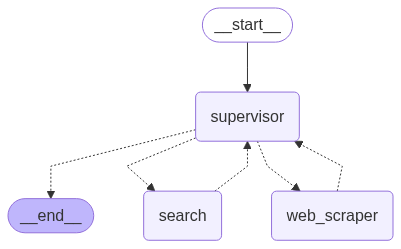

In [39]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()
research_graph

In [40]:
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

In [41]:
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"])

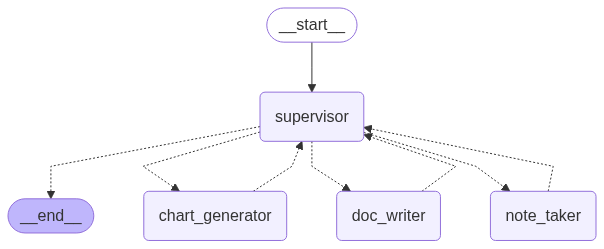

In [42]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()
paper_writing_graph

In [43]:
from langchain_core.messages import BaseMessage
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])
teams_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['research_team', 'writing_team', '__end__']]>

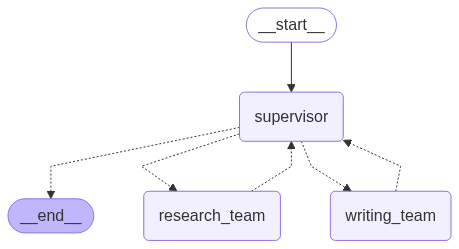

In [44]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()
super_graph

In [45]:
response=super_graph.invoke(
    {
        "messages": [
            ("user", "Write about transformer variants in production deployments.")
        ],
    })

In [46]:
response

{'messages': [HumanMessage(content='Write about transformer variants in production deployments.', additional_kwargs={}, response_metadata={}, id='12209b55-a84b-4610-a35c-10d2447bbbe8'),
  HumanMessage(content="## Transformer Variants in Production Deployments\n\nTransformers have significantly changed how machine learning is applied, particularly in natural language processing (NLP) and computer vision. Numerous transformer variants have been developed, each tailored for specific tasks and conditions. Familiarity with these variants can enhance efficiency and effectiveness in production deployments.\n\n### Common Transformer Variants\n\n1. **BERT (Bidirectional Encoder Representations from Transformers)**:\n   - **Use Case**: BERT excels in sentiment analysis, question answering, and tasks requiring contextual understanding. Its bi-directional processing considers words' contexts from both sides.\n\n2. **GPT (Generative Pre-trained Transformer)**:\n   - **Use Case**: GPT models, such a

In [47]:
response["messages"][-1].content

'The document "Transformer Variants in Production Deployments" and its outline have been successfully created and saved. If you need any further modifications or additional content, feel free to ask!'